In [2]:
import os
import sys
# Root folder
sys.path.append("../..")

from PIL import Image

from apis.owlv2 import OWLViT, visualize_image
from apis.sam import SAM, visualize_image
# from apis.language_model import GPT4V

In [3]:
def get_scene_graph_prompt(predicate):
    prompt = f'''The additional predicate is [{predicate}]'''
    meta_prompt = '''Generate the Scene Graph with the following format, with the given predicate to check if the object satify this. Where the node define the objects and edge define spatial relationship ['ON', 'INSIDE']. If the predicate is None, don't generate predicate.

nodes=
[
('apple1', 'predicate'),
('mat1', 'predicate'),
...
]

edges=
[
('ON', 'apple1', 'mat1'),
...
]


    '''
    return prompt, meta_prompt



In [4]:
import re

def parse_scene_graph(scene_graph):
    # Define patterns for nodes and edges
    node_pattern = re.compile(r"\('([a-zA-Z]+\d+)', (?:'([^']+)'|None)\)")
    edge_pattern = re.compile(r"\('([a-zA-Z]+)', '([a-zA-Z]+\d+)', '([a-zA-Z]+\d+)'\)")

    # Find all nodes and edges using regex
    nodes = node_pattern.findall(scene_graph)
    edges = edge_pattern.findall(scene_graph)

    # Filter nodes that include 'table' or 'chair' and collect remaining nodes
    filtered_nodes = [node for node in nodes if not ('table' in node[0].lower() or 'chair' in node[0].lower())]

    # Filter edges, ensuring neither source nor destination is a filtered-out object
    filtered_edges = [edge for edge in edges if not any('table' in node[0].lower() or 'chair' in node[0].lower() for node in filtered_nodes if node[0] in edge)]

    # Use a set to collect unique object classes from filtered nodes, removing numbers
    object_classes_set = set(re.sub(r'\d+', '', obj) for obj, _ in filtered_nodes)

    # Convert set to list to finalize the object classes
    object_classes = list(object_classes_set)

    return filtered_nodes, filtered_edges, object_classes

# Example scene graph as a string
scene_graph = '''
nodes=
[
('apple1', 'predicate'),
('mat1', None),
('table1', 'predicate'),
('chair2', 'predicate'),
('banana3', 'predicate'),
...
]

edges=
[
('ON', 'apple1', 'mat1'),
('ON', 'apple1', 'table1'),
('UNDER', 'banana3', 'chair2'),
...
]
'''

# Parse the scene graph
nodes, edges, object_classes = parse_scene_graph(scene_graph)

# Print the filtered nodes, edges, and object classes
print("Filtered Nodes:", nodes)
print("Filtered Edges:", edges)
print("Object Classes:", object_classes)


Filtered Nodes: [('apple1', 'predicate'), ('mat1', ''), ('banana3', 'predicate')]
Filtered Edges: [('ON', 'apple1', 'mat1'), ('ON', 'apple1', 'table1'), ('UNDER', 'banana3', 'chair2')]
Object Classes: ['mat', 'banana', 'apple']


In [10]:
detector = OWLViT()
sam = SAM()
# gpt4v = GPT4V()

import time
file_path = "./images/1.png"
image = Image.open(file_path)
# prompt = "where is the fruits?"
prompt, meta_prompt = get_scene_graph_prompt('wood')
# print(prompt)
scene_graph_string = gpt4v.chat(prompt, image, meta_prompt=meta_prompt)
print(scene_graph_string)
nodes, edges, object_classes = parse_scene_graph(scene_graph_string)
print("Nodes:", nodes)
print("Edges:", edges)
print("Object Classes:", object_classes)


nodes=
[
('orange1', None),
('orange2', None),
('orange3', None),
('orange4', None),
('bowl1', None),
('table1', 'wood'),
('chair1', 'wood'),
('chair2', 'wood'),
('chair3', 'wood'),
('chair4', 'wood'),
('book1', None),
('pen1', None)
]

edges=
[
('ON', 'orange1', 'table1'),
('ON', 'orange2', 'table1'),
('ON', 'orange3', 'table1'),
('ON', 'orange4', 'table1'),
('ON', 'bowl1', 'table1'),
('ON', 'book1', 'table1'),
('ON', 'pen1', 'table1'),
('ON', 'chair1', 'table1'),
('ON', 'chair2', 'table1'),
('ON', 'chair3', 'table1'),
('ON', 'chair4', 'table1')
]
Nodes: [('orange1', ''), ('orange2', ''), ('orange3', ''), ('orange4', ''), ('bowl1', ''), ('book1', ''), ('pen1', '')]
Edges: [('ON', 'orange1', 'table1'), ('ON', 'orange2', 'table1'), ('ON', 'orange3', 'table1'), ('ON', 'orange4', 'table1'), ('ON', 'bowl1', 'table1'), ('ON', 'book1', 'table1'), ('ON', 'pen1', 'table1'), ('ON', 'chair1', 'table1'), ('ON', 'chair2', 'table1'), ('ON', 'chair3', 'table1'), ('ON', 'chair4', 'table1')]
Object Cl

## Test detection

In [15]:
from image_utils import annotate_masks

text_queries = object_classes

time1 = time.time()

detected_objects = detector.detect_objects(
    image=image,
    text_queries=text_queries,
    bbox_score_top_k=25,
    bbox_conf_threshold=0.15
)
best_boxes = {}

for det in detected_objects:
    box_name = det["box_name"]
    if box_name not in best_boxes or det["score"] > best_boxes[box_name]["score"]:
        best_boxes[box_name] = det
        
# Check if any object of interest is missing in the detected objects
missing_objects = set(object_classes) - set(best_boxes.keys())
# if missing_objects:
#     raise print(f"Missing objects that were not detected or had no best box: {', '.join(missing_objects)}")
    
# Arrange boxes in the order of objects_of_interest
# boxes_of_interest = [best_boxes[name] for name in object_classes]

masks = sam.segment_by_bboxes(image=image, bboxes=[obj['bbox'] for obj in detected_objects])
segment_img = annotate_masks(
    image, 
    masks=[anno["segmentation"] for anno in masks],
    label_mode="1",
    alpha=0.5,
    draw_mask=True, 
    draw_mark=True, 
    draw_box=True
)

In [16]:
#visualize the segmented image
segment_img.show()

Gtk-Message: 11:47:55.887: Failed to load module "appmenu-gtk-module"

(eog:1663686): EOG-WARNING **: 11:47:56.303: Couldn't load icon: Icon 'image-loading' not present in theme breeze


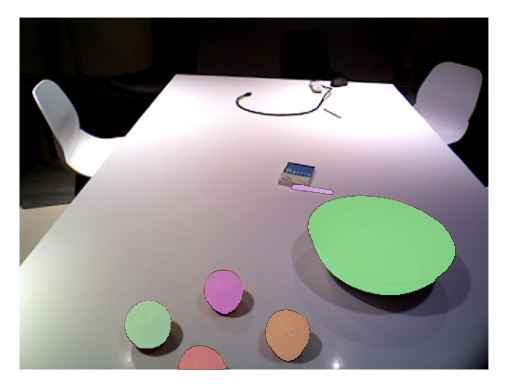

In [81]:
visualize_image(image, masks=[mask["segmentation"] for mask in masks])

In [59]:
# Example text queries
text_queries = object_classes

time1 = time.time()

det_data = detector.detect_objects(
    image=image,
    text_queries=text_queries,
    bbox_score_top_k=20,
    bbox_conf_threshold=0.18
)

time2 = time.time()
print(f"Time taken: {time2 - time1:.2f}s")

for i, item in enumerate(det_data):
    print(f"--- Detection {i + 1} ---")
    print(f"Box Name: {item['box_name']}")
    print(f"Score: {item['score']}")
    print(f"Box Coordinates: {item['bbox']}")

Time taken: 0.60s
--- Detection 1 ---
Box Name: pen
Score: 0.20827676355838776
Box Coordinates: [0.5662437081336975, 0.4709339141845703, 0.660847008228302, 0.500643789768219]
--- Detection 2 ---
Box Name: bowl
Score: 0.6086623668670654
Box Coordinates: [0.6116538643836975, 0.5017261505126953, 0.9120408892631531, 0.7734540700912476]
--- Detection 3 ---
Box Name: orange
Score: 0.6661786437034607
Box Coordinates: [0.39793500304222107, 0.7047455906867981, 0.477994441986084, 0.8233598470687866]
--- Detection 4 ---
Box Name: orange
Score: 0.6736894249916077
Box Coordinates: [0.23517169058322906, 0.7884793877601624, 0.3296838104724884, 0.9210554361343384]
--- Detection 5 ---
Box Name: orange
Score: 0.6449102163314819
Box Coordinates: [0.5230720639228821, 0.8131251931190491, 0.6156795024871826, 0.9446604251861572]
--- Detection 6 ---
Box Name: orange
Score: 0.6196730136871338
Box Coordinates: [0.3432196378707886, 0.9092100262641907, 0.4436177611351013, 0.9724534749984741]


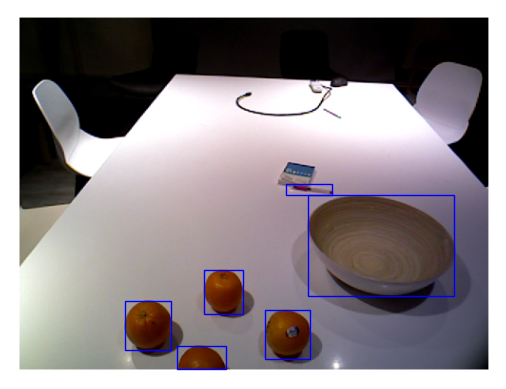

In [66]:
visualize_image(image, bboxes=[obj["bbox"] for obj in det_data])